# IBM Data Science Capstone

## Week 5

### Business Problem

**Kuala Lumpur** is a multicultural city located at the heart of **Malaysia**. It is home to hundreds of thousands of tourists every year. It is also a hub for universities, businesses, restaurants and a lot more destinations. 

My client wants to open an **African restaurant** in Kuala Lumpur. Kuala Lumpur is huge. Hence, it is important to identify a good location to open a restaurant. For this we will need to identify the suburbs in Kuala Lumpur and use Foursquare API to access the location data.

The **goal** here is to divide Kuala Lumpur suburbs into various clusters. Once the suburbs are clustered, we will look for the best cluster of suburbs to open our client's African Restaurant.

I will start by getting the names of all the suburbs in Kuala Lumpur. For this I will use the wikipedia page - https://en.wikipedia.org/wiki/Category:Suburbs_in_Kuala_Lumpur

In [1]:
#Importing libraries

import numpy as np
import pandas as pd
#pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

import json #library to handle json files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import geocoder

import requests #library to handle requests
from pandas.io.json import json_normalize #transform JSON file into pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries imported..')

Libraries imported..


### Get the the names of the suburbs in Kuala Lumpur from the wikipedia page

In [2]:
#The below function takes in wikipedia page and an empty list as input
#Return a dataframe that contains the list of the suburbs/neighborhoods

def create_dataframe_from_wiki(page):
    
    #import beautiful soup library
    from bs4 import BeautifulSoup as bs
    
    #send get request method and create a list of suburbs
    data = requests.get(page).text
    soup = bs(data,'html.parser')
    
    list_of_suburbs = []
    
    for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
        list_of_suburbs.append(row.text)
    
    #create a dataframe containing all the names of the suburbs
    suburb_df = pd.DataFrame(columns = ['SuburbName'], data = list_of_suburbs)
    
    return suburb_df

In [3]:
#Using the function to create the dataframe

wikipedia_page = 'https://en.wikipedia.org/wiki/Category:Suburbs_in_Kuala_Lumpur'
suburb_df = create_dataframe_from_wiki(wikipedia_page)

In [4]:
print("There are {} suburbs in Kuala Lumpur".format(suburb_df.shape[0]))
suburb_df.head(n = 10)

There are 71 suburbs in Kuala Lumpur


,SuburbName
0,Alam Damai
1,"Ampang, Kuala Lumpur"
2,Bandar Menjalara
3,Bandar Sri Permaisuri
4,Bandar Tasik Selatan
5,Bandar Tun Razak
6,Bangsar
7,Bangsar Park
8,Bangsar South
9,Batu 11 Cheras


As seen above, there are **70 suburbs** in Kuala Lumpur.

Since my client wants to open a restaurant in one of these suburbs - 
* Get the location data (Latitude and Longitude) of each suburb.
* Use Foursquare API to get venues in each of the suburb

#### Location data for each suburb

In [5]:
#function to get coordinates

def get_coordinates(location_names,dataframe):
    
    list_of_coords = []
    
    for location in location_names:
        location_g = geocoder.arcgis('{}, Kuala Lumpur, Malaysia'.format(location))
        location_coord = location_g.latlng
        list_of_coords.append(location_coord)
        
    dataframe[['Latitude','Longitude']] = list_of_coords[:]
    
    print('{} The dataframe has been modified with latitude and longitude information'.format(dataframe))

In [6]:
#applying the function for our suburb_df dataframe

get_coordinates(suburb_df['SuburbName'],suburb_df)

                      SuburbName  Latitude   Longitude
0                     Alam Damai  3.057690  101.743880
1           Ampang, Kuala Lumpur  3.148499  101.696728
2               Bandar Menjalara  3.190350  101.625450
3          Bandar Sri Permaisuri  3.103910  101.712260
4           Bandar Tasik Selatan  3.072750  101.714610
5               Bandar Tun Razak  3.082760  101.722810
6                        Bangsar  3.129200  101.678440
7                   Bangsar Park  3.129200  101.678440
8                  Bangsar South  3.111020  101.662830
9                 Batu 11 Cheras  3.061870  101.746750
10            Batu, Kuala Lumpur  3.147890  101.694050
11                   Brickfields  3.129160  101.684060
12                 Bukit Bintang  3.147770  101.708550
13                   Bukit Jalil  3.057810  101.689650
14                   Bukit Kiara  3.143480  101.644330
15                   Bukit Nanas  3.148609  101.699854
16                Bukit Petaling  3.129290  101.698960
17        

In [7]:
suburb_df.head() 

,SuburbName,Latitude,Longitude
0,Alam Damai,3.057690,101.743880
1,"Ampang, Kuala Lumpur",3.148499,101.696728
2,Bandar Menjalara,3.190350,101.625450
3,Bandar Sri Permaisuri,3.103910,101.712260
4,Bandar Tasik Selatan,3.072750,101.714610


As seen in the above dataframe, coordinates information has been added to each suburb in Kuala Lumpur. We will use this information to develop a map. 

#### The Map of Kuala Lumpur

In [8]:
def get_coordinate_information(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude_of_address = location.latitude
    longitude_of_address = location.longitude 
    coords_of_address = [latitude_of_address,longitude_of_address]
    return coords_of_address

In [9]:
kl_address = 'Kuala Lumpur, Malaysia'
kl_coordinates = get_coordinate_information(kl_address)
kl_coordinates

[3.1516964, 101.6942371]

In [10]:
#function to draw a map of the city with suburbs in it

def draw_map(coordinates_of_city, dataframe_of_suburbs, zoom_start = 10):
    
    map_city = folium.Map(location = [coordinates_of_city[0],coordinates_of_city[1]],zoom_start = 10)

    for suburb, lat, lng in zip(dataframe_of_suburbs.iloc[:,0],dataframe_of_suburbs.iloc[:,1],
                                   dataframe_of_suburbs.iloc[:,2],
                                   ):
        label = '{}'.format(suburb)
        label = folium.Popup(label, parse_html = True)
        folium.CircleMarker(
        [lat,lng],
        popup = label,
        fill = True,
        fill_color = '317y6cc',
        parse_html = True).add_to(map_city)

    return map_city

In [11]:
draw_map(kl_coordinates,suburb_df)

### Exploring the Suburbs in KL using Foursquare API

In [12]:
#foursquare credentials

CLIENT_ID = '######################' # your Foursquare ID
CLIENT_SECRET = '#######################' # your Foursquare Secret
VERSION = '######' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [13]:
#(taken from week 3 lab)
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
kl_venues_all = getNearbyVenues(names=suburb_df['SuburbName'],
                                   latitudes=suburb_df['Latitude'],
                                   longitudes=suburb_df['Longitude']
                                  )

In [15]:
#kl_venues_all.to_csv('../Data_Science_Capstone/kl_venues_all.txt',sep='\t',index=False)

In [16]:
print(kl_venues_all.shape)
kl_venues_all.head()

(2622, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alam Damai,3.05769,101.74388,Machi Noodle 妈子面,3.057695,101.746635,Noodle House
1,Alam Damai,3.05769,101.74388,Darma Motor,3.054160,101.744328,Motorcycle Shop
2,Alam Damai,3.05769,101.74388,628火焰鑫茶室,3.058442,101.747947,Chinese Restaurant
3,Alam Damai,3.05769,101.74388,閒茶素食店 Leisure Tea Vegetarian,3.057673,101.747258,Vegetarian / Vegan Restaurant
4,Alam Damai,3.05769,101.74388,Roti Canai Perindu,3.055071,101.740574,Breakfast Spot


As seen in the above dataframe, we have over 2500 venues in these suburbs.

Visualising the venue count in the suburbs

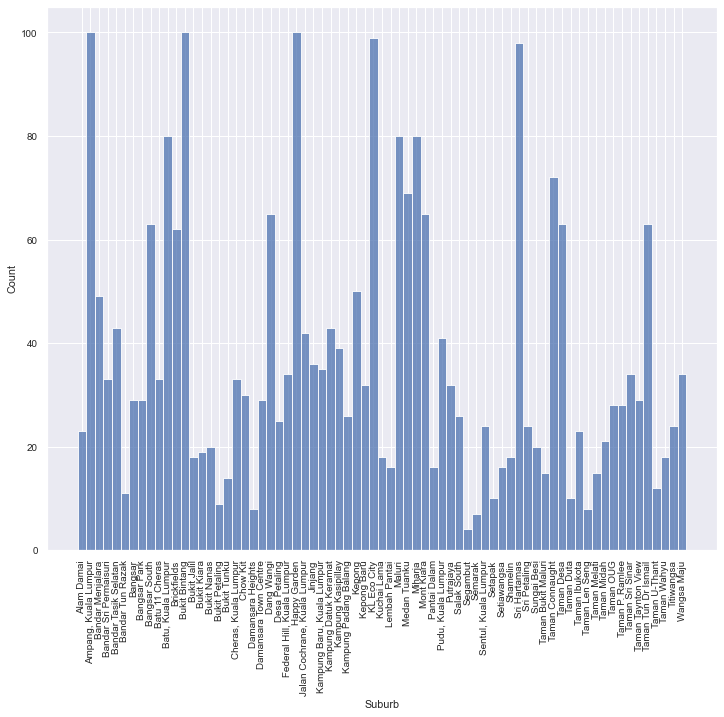

In [17]:
plt.figure(figsize = (12,10))

sns.set(font_scale = 0.9)
sns.histplot(kl_venues_all['Suburb'])
plt.xticks(rotation = 90)

plt.show()

In [18]:
#Lets see how many venues were returned for each of these suburbs

kl_venues_grouped = kl_venues_all.groupby(by = 'Suburb').count()['Venue'].sort_values()
kl_venues_grouped

Suburb
Segambut                          4
Semarak                           7
Damansara Heights                 8
Taman Len Seng                    8
Bukit Petaling                    9
Taman Duta                       10
Setapak                          10
Bandar Tun Razak                 11
Taman U-Thant                    12
Bukit Tunku                      14
Taman Melati                     15
Taman Bukit Maluri               15
Lembah Pantai                    16
Pantai Dalam                     16
Setiawangsa                      16
Kuchai Lama                      18
Bukit Jalil                      18
Taman Wahyu                      18
Shamelin                         18
Bukit Kiara                      19
Sungai Besi                      20
Bukit Nanas                      20
Taman Midah                      21
Taman Ibukota                    23
Alam Damai                       23
Sentul, Kuala Lumpur             24
Sri Petaling                     24
Titiwangsa           

In [19]:
venue_category_list = list(kl_venues_all['Venue Category'].unique())
print('There are {} venue categories and they are - \n\n {}'.format(len(venue_category_list),venue_category_list))

There are 269 venue categories and they are - 

 ['Noodle House', 'Motorcycle Shop', 'Chinese Restaurant', 'Vegetarian / Vegan Restaurant', 'Breakfast Spot', 'Dim Sum Restaurant', 'Farmers Market', 'Dessert Shop', 'Convenience Store', 'Japanese Restaurant', 'Asian Restaurant', 'Hakka Restaurant', 'Fast Food Restaurant', 'Pharmacy', 'Food Truck', 'Food Court', 'Auto Garage', 'Indian Restaurant', 'Malay Restaurant', 'Hostel', 'South Indian Restaurant', 'Exhibit', 'Chettinad Restaurant', 'Monument / Landmark', 'Park', 'Athletics & Sports', 'Hotel', 'Restaurant', 'Café', 'Coffee Shop', 'Juice Bar', 'Gym', 'Bed & Breakfast', 'Theater', 'Bakery', 'Flower Shop', 'Art Gallery', 'Bridal Shop', 'Wine Bar', 'Food Stand', 'Flea Market', 'Bar', 'Filipino Restaurant', 'Deli / Bodega', 'Cupcake Shop', 'Music Venue', 'Other Nightlife', 'Arts & Crafts Store', 'Clothing Store', 'Music Store', 'Mobile Phone Shop', 'Shop & Service', 'Bubble Tea Shop', 'Club House', 'Sandwich Place', 'Plaza', 'Ice Cream Sh

From the 274 venue categories, we will create a dataframe with only restaurants.

In [20]:
kl_restaurants = kl_venues_all[kl_venues_all['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
print(kl_restaurants.shape[0])
kl_restaurants

1056


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alam Damai,3.057690,101.743880,628火焰鑫茶室,3.058442,101.747947,Chinese Restaurant
1,Alam Damai,3.057690,101.743880,閒茶素食店 Leisure Tea Vegetarian,3.057673,101.747258,Vegetarian / Vegan Restaurant
2,Alam Damai,3.057690,101.743880,Heng Kee Tim Sum 興記點心,3.057513,101.747191,Dim Sum Restaurant
3,Alam Damai,3.057690,101.743880,Restaurant Sweetland 甜园美食中心,3.057495,101.747725,Chinese Restaurant
4,Alam Damai,3.057690,101.743880,SUSHI MENTAI,3.057821,101.748145,Japanese Restaurant
5,Alam Damai,3.057690,101.743880,Hakka Marble Restaurant (美浩天),3.057832,101.748205,Asian Restaurant
6,Alam Damai,3.057690,101.743880,A Teh 客家手拉特制手拉板面,3.057740,101.746709,Hakka Restaurant
7,Alam Damai,3.057690,101.743880,A&W,3.053647,101.743981,Fast Food Restaurant
8,Alam Damai,3.057690,101.743880,Restoran Nasi Kandar Marhabah,3.054719,101.743770,Indian Restaurant
9,Alam Damai,3.057690,101.743880,金专饮食坊,3.057990,101.747859,Chinese Restaurant


As seen in the above dataframe, there are 1036 restaurants across all the suburbs in KL

In [21]:
#Analysing each suburb

kl_restaurants_onehot = pd.get_dummies(kl_restaurants[['Venue Category']], prefix="", prefix_sep="")
len(kl_restaurants_onehot.columns.to_list())
kl_restaurants_onehot.columns = kl_restaurants_onehot.columns.str.replace(' ','_')
kl_restaurants_onehot.columns = kl_restaurants_onehot.columns.str.replace('/','')
len(kl_restaurants_onehot.columns.to_list())
kl_restaurants_onehot.head()
kl_restaurants_onehot['Suburb'] = kl_restaurants['Suburb']
kl_restaurants_onehot.head()
columns_list = kl_restaurants_onehot.columns.to_list()
columns_list.remove('Suburb')
columns_list.insert(0,'Suburb')
kl_restaurants_onehot = kl_restaurants_onehot[columns_list]
kl_restaurants_onehot.head()

kl_restaurants_grouped = kl_restaurants_onehot.groupby('Suburb').mean().reset_index()
kl_restaurants_grouped.head()

,Suburb,African_Restaurant,American_Restaurant,Asian_Restaurant,Belgian_Restaurant,Cantonese_Restaurant,Chettinad_Restaurant,Chinese_Restaurant,Comfort_Food_Restaurant,Dim_Sum_Restaurant,Dumpling_Restaurant,Falafel_Restaurant,Fast_Food_Restaurant,Filipino_Restaurant,French_Restaurant,Hainan_Restaurant,Hakka_Restaurant,Halal_Restaurant,Hotpot_Restaurant,Imperial_Restaurant,Indian_Restaurant,Indonesian_Restaurant,Iraqi_Restaurant,Italian_Restaurant,Japanese_Restaurant,Kebab_Restaurant,Korean_Restaurant,Kushikatsu_Restaurant,Latin_American_Restaurant,Lebanese_Restaurant,Malay_Restaurant,Mamak_Restaurant,Mediterranean_Restaurant,Mexican_Restaurant,Middle_Eastern_Restaurant,Modern_European_Restaurant,Moroccan_Restaurant,North_Indian_Restaurant,Padangnese_Restaurant,Portuguese_Restaurant,Ramen_Restaurant,Restaurant,Scandinavian_Restaurant,Seafood_Restaurant,South_Indian_Restaurant,Spanish_Restaurant,Sri_Lankan_Restaurant,Sushi_Restaurant,Szechuan_Restaurant,Taiwanese_Restaurant,Tapas_Restaurant,Thai_Restaurant,Udon_Restaurant,Vegetarian__Vegan_Restaurant,Vietnamese_Restaurant,Yakitori_Restaurant
0,Alam Damai,0.00,0.0,0.090909,0.0,0.0,0.000000,0.272727,0.000000,0.090909,0.0,0.0,0.090909,0.000000,0.0,0.0,0.090909,0.0,0.00,0.0,0.090909,0.0000,0.0,0.0,0.090909,0.0,0.00,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.0,0.0
1,"Ampang, Kuala Lumpur",0.00,0.0,0.162162,0.0,0.0,0.027027,0.108108,0.000000,0.000000,0.0,0.0,0.000000,0.027027,0.0,0.0,0.000000,0.0,0.00,0.0,0.405405,0.0000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.081081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,0.0,0.081081,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.054054,0.0,0.0
2,Bandar Menjalara,0.05,0.0,0.100000,0.0,0.0,0.000000,0.350000,0.000000,0.000000,0.0,0.0,0.050000,0.000000,0.0,0.0,0.000000,0.0,0.05,0.0,0.000000,0.0500,0.0,0.0,0.050000,0.0,0.05,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.000000,0.05,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.050000,0.0,0.0
3,Bandar Sri Permaisuri,0.00,0.0,0.000000,0.0,0.0,0.000000,0.125000,0.000000,0.062500,0.0,0.0,0.062500,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.062500,0.1875,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.187500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187500,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.000000,0.0,0.0
4,Bandar Tasik Selatan,0.00,0.0,0.384615,0.0,0.0,0.000000,0.000000,0.076923,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.307692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.153846,0.0,0.000000,0.0,0.0


## Clustering

In [22]:
clusters = 3

#preparing the df
clustering_df = kl_restaurants_grouped.drop('Suburb',1)

#running k means
kmeans = KMeans(n_clusters = clusters, random_state = 30)

kmeans.fit(clustering_df)

kmeans.labels_

array([0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 0, 0, 1, 2, 2,
       2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 1, 2, 1, 0, 2, 2, 2, 2,
       1, 1, 2, 0, 0], dtype=int32)

In [23]:
#add the cluster number back to the dataframe

kl_restaurants_grouped['Clusters'] = kmeans.labels_
kl_restaurants_grouped.head()

,Suburb,African_Restaurant,American_Restaurant,Asian_Restaurant,Belgian_Restaurant,Cantonese_Restaurant,Chettinad_Restaurant,Chinese_Restaurant,Comfort_Food_Restaurant,Dim_Sum_Restaurant,Dumpling_Restaurant,Falafel_Restaurant,Fast_Food_Restaurant,Filipino_Restaurant,French_Restaurant,Hainan_Restaurant,Hakka_Restaurant,Halal_Restaurant,Hotpot_Restaurant,Imperial_Restaurant,Indian_Restaurant,Indonesian_Restaurant,Iraqi_Restaurant,Italian_Restaurant,Japanese_Restaurant,Kebab_Restaurant,Korean_Restaurant,Kushikatsu_Restaurant,Latin_American_Restaurant,Lebanese_Restaurant,Malay_Restaurant,Mamak_Restaurant,Mediterranean_Restaurant,Mexican_Restaurant,Middle_Eastern_Restaurant,Modern_European_Restaurant,Moroccan_Restaurant,North_Indian_Restaurant,Padangnese_Restaurant,Portuguese_Restaurant,Ramen_Restaurant,Restaurant,Scandinavian_Restaurant,Seafood_Restaurant,South_Indian_Restaurant,Spanish_Restaurant,Sri_Lankan_Restaurant,Sushi_Restaurant,Szechuan_Restaurant,Taiwanese_Restaurant,Tapas_Restaurant,Thai_Restaurant,Udon_Restaurant,Vegetarian__Vegan_Restaurant,Vietnamese_Restaurant,Yakitori_Restaurant,Clusters
0,Alam Damai,0.00,0.0,0.090909,0.0,0.0,0.000000,0.272727,0.000000,0.090909,0.0,0.0,0.090909,0.000000,0.0,0.0,0.090909,0.0,0.00,0.0,0.090909,0.0000,0.0,0.0,0.090909,0.0,0.00,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.0,0.0,0
1,"Ampang, Kuala Lumpur",0.00,0.0,0.162162,0.0,0.0,0.027027,0.108108,0.000000,0.000000,0.0,0.0,0.000000,0.027027,0.0,0.0,0.000000,0.0,0.00,0.0,0.405405,0.0000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.081081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,0.0,0.081081,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.054054,0.0,0.0,0
2,Bandar Menjalara,0.05,0.0,0.100000,0.0,0.0,0.000000,0.350000,0.000000,0.000000,0.0,0.0,0.050000,0.000000,0.0,0.0,0.000000,0.0,0.05,0.0,0.000000,0.0500,0.0,0.0,0.050000,0.0,0.05,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.000000,0.05,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.050000,0.0,0.0,2
3,Bandar Sri Permaisuri,0.00,0.0,0.000000,0.0,0.0,0.000000,0.125000,0.000000,0.062500,0.0,0.0,0.062500,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.062500,0.1875,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.187500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187500,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.000000,0.0,0.0,0
4,Bandar Tasik Selatan,0.00,0.0,0.384615,0.0,0.0,0.000000,0.000000,0.076923,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.307692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.153846,0.0,0.000000,0.0,0.0,1


In [24]:
#Printing the suburb and its clusters

for nbhd, c in zip(kl_restaurants_grouped.iloc[:, 0], kl_restaurants_grouped.iloc[:, -1]):
    print("The Suburb, {} belongs to => Cluster {}".format(nbhd,c))

The Suburb, Alam Damai belongs to => Cluster 0
The Suburb, Ampang, Kuala Lumpur belongs to => Cluster 0
The Suburb, Bandar Menjalara belongs to => Cluster 2
The Suburb, Bandar Sri Permaisuri belongs to => Cluster 0
The Suburb, Bandar Tasik Selatan belongs to => Cluster 1
The Suburb, Bandar Tun Razak belongs to => Cluster 1
The Suburb, Bangsar belongs to => Cluster 1
The Suburb, Bangsar Park belongs to => Cluster 1
The Suburb, Bangsar South belongs to => Cluster 0
The Suburb, Batu 11 Cheras belongs to => Cluster 0
The Suburb, Batu, Kuala Lumpur belongs to => Cluster 0
The Suburb, Brickfields belongs to => Cluster 0
The Suburb, Bukit Bintang belongs to => Cluster 0
The Suburb, Bukit Jalil belongs to => Cluster 0
The Suburb, Bukit Kiara belongs to => Cluster 0
The Suburb, Bukit Nanas belongs to => Cluster 0
The Suburb, Bukit Petaling belongs to => Cluster 1
The Suburb, Bukit Tunku belongs to => Cluster 0
The Suburb, Cheras, Kuala Lumpur belongs to => Cluster 0
The Suburb, Chow Kit belongs

/Users/rfarhad-c/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


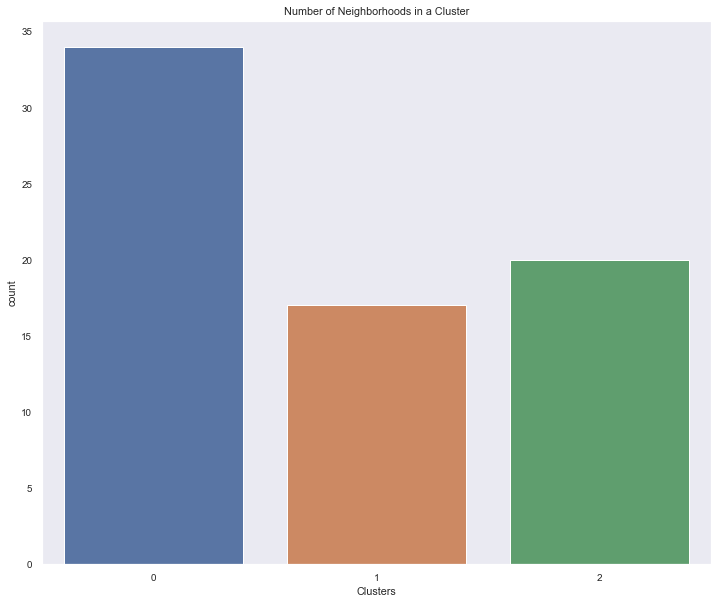

In [25]:
#Lets visualize this dataframe

plt.figure(figsize = (12,10))

sns.countplot(kl_restaurants_grouped['Clusters'])

plt.title("Number of Neighborhoods in a Cluster")
plt.grid(False)
plt.xticks([0,1,2])

plt.show()

In [26]:
cluster_0 = kl_restaurants_grouped[kl_restaurants_grouped['Clusters'] == 0].reset_index(drop = True)
cluster_0

,Suburb,African_Restaurant,American_Restaurant,Asian_Restaurant,Belgian_Restaurant,Cantonese_Restaurant,Chettinad_Restaurant,Chinese_Restaurant,Comfort_Food_Restaurant,Dim_Sum_Restaurant,Dumpling_Restaurant,Falafel_Restaurant,Fast_Food_Restaurant,Filipino_Restaurant,French_Restaurant,Hainan_Restaurant,Hakka_Restaurant,Halal_Restaurant,Hotpot_Restaurant,Imperial_Restaurant,Indian_Restaurant,Indonesian_Restaurant,Iraqi_Restaurant,Italian_Restaurant,Japanese_Restaurant,Kebab_Restaurant,Korean_Restaurant,Kushikatsu_Restaurant,Latin_American_Restaurant,Lebanese_Restaurant,Malay_Restaurant,Mamak_Restaurant,Mediterranean_Restaurant,Mexican_Restaurant,Middle_Eastern_Restaurant,Modern_European_Restaurant,Moroccan_Restaurant,North_Indian_Restaurant,Padangnese_Restaurant,Portuguese_Restaurant,Ramen_Restaurant,Restaurant,Scandinavian_Restaurant,Seafood_Restaurant,South_Indian_Restaurant,Spanish_Restaurant,Sri_Lankan_Restaurant,Sushi_Restaurant,Szechuan_Restaurant,Taiwanese_Restaurant,Tapas_Restaurant,Thai_Restaurant,Udon_Restaurant,Vegetarian__Vegan_Restaurant,Vietnamese_Restaurant,Yakitori_Restaurant,Clusters
0,Alam Damai,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.272727,0.000000,0.090909,0.000000,0.0,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.0,0.090909,0.000000,0.000000,0.000000,0.090909,0.0,0.000000,0.000000,0.0,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0
1,"Ampang, Kuala Lumpur",0.000000,0.000000,0.162162,0.000000,0.000000,0.027027,0.108108,0.000000,0.000000,0.000000,0.0,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.405405,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.081081,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.054054,0.000000,0.000000,0.081081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054054,0.000000,0.000000,0
2,Bandar Sri Permaisuri,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.062500,0.000000,0.0,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.062500,0.187500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0
3,Bangsar South,0.000000,0.047619,0.000000,0.047619,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.0,0.095238,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.0,0.047619,0.000000,0.000000,0.095238,0.095238,0.0,0.000000,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,0.000000,0.047619,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0
4,Batu 11 Cheras,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.235294,0.000000,0.058824,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.058824,0.058824,0.000000,0.0,0.117647,0.000000,0.000000,0.000000,0.058824,0.0,0.000000,0.000000,0.0,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,0.000000,0.000000,0
5,"Batu, Kuala Lumpur",0.000000,0.000000,0.166667,0.000000,0.000000,0.041667,0.125000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.375000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.083333,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000

In [27]:
cluster_0['African_Restaurant'].sum(axis = 0)

0.4948841698841699

In [28]:
cluster_1 = kl_restaurants_grouped[kl_restaurants_grouped['Clusters'] == 1].reset_index(drop = True)
cluster_1

,Suburb,African_Restaurant,American_Restaurant,Asian_Restaurant,Belgian_Restaurant,Cantonese_Restaurant,Chettinad_Restaurant,Chinese_Restaurant,Comfort_Food_Restaurant,Dim_Sum_Restaurant,Dumpling_Restaurant,Falafel_Restaurant,Fast_Food_Restaurant,Filipino_Restaurant,French_Restaurant,Hainan_Restaurant,Hakka_Restaurant,Halal_Restaurant,Hotpot_Restaurant,Imperial_Restaurant,Indian_Restaurant,Indonesian_Restaurant,Iraqi_Restaurant,Italian_Restaurant,Japanese_Restaurant,Kebab_Restaurant,Korean_Restaurant,Kushikatsu_Restaurant,Latin_American_Restaurant,Lebanese_Restaurant,Malay_Restaurant,Mamak_Restaurant,Mediterranean_Restaurant,Mexican_Restaurant,Middle_Eastern_Restaurant,Modern_European_Restaurant,Moroccan_Restaurant,North_Indian_Restaurant,Padangnese_Restaurant,Portuguese_Restaurant,Ramen_Restaurant,Restaurant,Scandinavian_Restaurant,Seafood_Restaurant,South_Indian_Restaurant,Spanish_Restaurant,Sri_Lankan_Restaurant,Sushi_Restaurant,Szechuan_Restaurant,Taiwanese_Restaurant,Tapas_Restaurant,Thai_Restaurant,Udon_Restaurant,Vegetarian__Vegan_Restaurant,Vietnamese_Restaurant,Yakitori_Restaurant,Clusters
0,Bandar Tasik Selatan,0.0,0.000000,0.384615,0.0,0.0,0.0,0.000000,0.076923,0.000000,0.0,0.00,0.000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.307692,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.153846,0.0,0.0,0.0,0.0,1
1,Bandar Tun Razak,0.0,0.000000,0.333333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
2,Bangsar,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.125,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.375000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
3,Bangsar Park,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.125,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.375000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
4,Bukit Petaling,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.25,0.000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
5,Chow Kit,0.0,0.000000,0.076923,0.0,0.0,0.0,0.153846,0.000000,0.000000,0.0,0.00,0.000,0.0,0.000000,0.0,0.0,0.076923,0.0,0.0,0.000000,0.153846,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.384615,0.0,0.0,0.0,0.076923,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.076923,0.0,0.0,0.0,0.0,1
6,Dang Wangi,0.0,0.055556,0.055556,0.0,0.0,0.0,0.055556,0.000000,0.055556,0.0,0.00,0.000,0.0,0.000000,0.0,0.0,0.055556,0.0,0.0,0.111111,0.055556,0.0,0.000000,0.0,0.0,0.055556,0.0,0.0,0.0,0.277778,0.0,0.0,0.0,0.055556,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0,0.0,1
7,"Kampung Baru, Kuala Lumpur",0.0,0.000000,0.040000,0.0,0.0,0.0,0.000000,0.040000,0.000000,0.0,0.00,0.000,0.0,0.000000,0.0,0.0,0.040000,0.0,0.0,0.040000,0.080000,0.0,0.040000,0.0,0.0,0.000000,0.0,0.0,0.0,0.400000,0.0,0.0,0.0,0.080000,0.0,0.04,0.0,0.04,0.0,0.0,0.080000,0.0,0.080000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
8,Kampung Datuk Keramat,0.0,0.050000,0.100000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.050,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.100000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.450000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0

In [29]:
cluster_1['African_Restaurant'].sum(axis = 0)

0.0

In [30]:
cluster_2 = kl_restaurants_grouped[kl_restaurants_grouped['Clusters'] == 2].reset_index(drop = True)
cluster_2

,Suburb,African_Restaurant,American_Restaurant,Asian_Restaurant,Belgian_Restaurant,Cantonese_Restaurant,Chettinad_Restaurant,Chinese_Restaurant,Comfort_Food_Restaurant,Dim_Sum_Restaurant,Dumpling_Restaurant,Falafel_Restaurant,Fast_Food_Restaurant,Filipino_Restaurant,French_Restaurant,Hainan_Restaurant,Hakka_Restaurant,Halal_Restaurant,Hotpot_Restaurant,Imperial_Restaurant,Indian_Restaurant,Indonesian_Restaurant,Iraqi_Restaurant,Italian_Restaurant,Japanese_Restaurant,Kebab_Restaurant,Korean_Restaurant,Kushikatsu_Restaurant,Latin_American_Restaurant,Lebanese_Restaurant,Malay_Restaurant,Mamak_Restaurant,Mediterranean_Restaurant,Mexican_Restaurant,Middle_Eastern_Restaurant,Modern_European_Restaurant,Moroccan_Restaurant,North_Indian_Restaurant,Padangnese_Restaurant,Portuguese_Restaurant,Ramen_Restaurant,Restaurant,Scandinavian_Restaurant,Seafood_Restaurant,South_Indian_Restaurant,Spanish_Restaurant,Sri_Lankan_Restaurant,Sushi_Restaurant,Szechuan_Restaurant,Taiwanese_Restaurant,Tapas_Restaurant,Thai_Restaurant,Udon_Restaurant,Vegetarian__Vegan_Restaurant,Vietnamese_Restaurant,Yakitori_Restaurant,Clusters
0,Bandar Menjalara,0.05,0.0,0.100000,0.0,0.000000,0.0,0.350000,0.000000,0.000000,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.000000,0.050000,0.0,0.000000,0.05,0.0,0.0,0.050000,0.000,0.050000,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.050000,0.0,0.000000,0.0,0.05,0.0,0.000000,0.0,0.0,0.0,0.050000,0.0,0.050000,0.000000,0.0,2
1,Jinjang,0.00,0.0,0.272727,0.0,0.000000,0.0,0.590909,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.045455,0.0,0.045455,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.045455,0.000000,0.0,2
2,Kampung Kasipillay,0.00,0.0,0.200000,0.0,0.000000,0.0,0.360000,0.000000,0.080000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.200000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.080000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.040000,0.0,0.040000,0.000000,0.0,2
3,Kepong,0.00,0.0,0.045455,0.0,0.000000,0.0,0.454545,0.045455,0.045455,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.045455,0.00,0.0,0.0,0.090909,0.000,0.000000,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.045455,0.0,0.045455,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.000000,0.045455,0.0,2
4,Kepong Baru,0.00,0.0,0.190476,0.0,0.000000,0.0,0.571429,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.047619,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.095238,0.0,0.095238,0.000000,0.0,2
5,Kuchai Lama,0.00,0.0,0.142857,0.0,0.000000,0.0,0.714286,0.000000,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.071429,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,2
6,"Pudu, Kuala Lumpur",0.00,0.0,0.043478,0.0,0.000000,0.0,0.913043,0.000000,0.043478,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,2
7,Putrajaya,0.00,0.0,0.200000,0.0,0.000000,0.0,0.400000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.1,0.100000,0.00,0.0,0.0,0.000000,0.000,0.100000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.000000,0.0,2
8,Salak South,0.00,0.0,0.142857,0.0,0.000000,0.0,0.714286,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.142857,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.000

In [31]:
cluster_2['African_Restaurant'].sum(axis = 0)

0.05

#### Visualizing the cluster

In [32]:
kl_merge = pd.merge(kl_restaurants_grouped[['Suburb','Clusters']],kl_restaurants[['Suburb','Suburb Latitude','Suburb Longitude']].drop_duplicates(), how = 'inner', on = 'Suburb')
kl_merge

,Suburb,Clusters,Suburb Latitude,Suburb Longitude
0,Alam Damai,0,3.057690,101.743880
1,"Ampang, Kuala Lumpur",0,3.148499,101.696728
2,Bandar Menjalara,2,3.190350,101.625450
3,Bandar Sri Permaisuri,0,3.103910,101.712260
4,Bandar Tasik Selatan,1,3.072750,101.714610
5,Bandar Tun Razak,1,3.082760,101.722810
6,Bangsar,1,3.129200,101.678440
7,Bangsar Park,1,3.129200,101.678440
8,Bangsar South,0,3.111020,101.662830
9,Batu 11 Cheras,0,3.061870,101.746750


In [33]:
# create map
map_clusters = folium.Map(location=[kl_coordinates[0], kl_coordinates[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merge['Suburb Latitude'], kl_merge['Suburb Longitude'], kl_merge['Suburb'], kl_merge['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see **cluster 0** and **cluster 2** has the most number of African Restaurants. There are no African restaurants in **cluster 1**. Hence it would be a good opportunity for the client to open a restuarant in any of the suburbs in Cluster 1. Cluster 1 contains some of the crowded regions in Kuala Lumpur such as Bangsar, KL Eco City etc. Hence, opening an African Restaurant here would be a good idea for our client.

# Thank you. 